In [1]:
import os
loc = 'drive/My Drive/Signature_Verification_CNN'

# **Importing Libraries**

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import stats

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import Dropout


from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from tensorflow.keras.layers import BatchNormalization, MaxPool2D,Concatenate,Lambda,Flatten,Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.models import Model

from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# **Preparing the dataset**

In [6]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
from itertools import combinations

def imagePreprocess(image,size):# Size in format img_width,img_height
    image=cv2.resize(image, size) 
    #(thresh, image) = cv2.threshold(image, 150, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) # grayscale to binary using threshold
    image = image/255
    return image

def getData(loc,name_file,size,dic):
    img_list = []
    l = len(name_file)
    counter = 0
    for name in name_file:
        if counter==int(l/4):
          print("25% Completed..")
        elif counter==int(l/2):
          print("50% Completed..")
        elif counter==int(3*l/2):
          print("75% Completed..")
        counter+=1

        try:
            img = cv2.imread(os.path.join(loc,name),0)
            img = imagePreprocess(img,size)
            img = img.reshape((size[0],size[1],1))
            img_list.append(name)
            dic[name] = img
        except:
            print("Couldn't import ",name,"in Location:",loc)
            continue
    print("100% Completed")
    return img_list

def getDataset3(data, dic, size):
    lis = []
    for c in range(0,len(data)):
        if c == len(data)//2:print("50% Complete")
        if c == len(data)//4:print("25% Complete")
        if c == 3*len(data)//4:print("75% Complete")
        i = data[c]
        img = np.asarray(Image.open(os.path.join('/kaggle/input/bhsig260-verif/BHSig260/Hindi', i)).convert('L'))
        img = imagePreprocess(img ,size)
        img = img.reshape((size[0],size[1],1))
        lis.append(i)
        dic[i] = img
    print('100% Complete')
    return lis

def getDataset3_B(data, dic, size):
    lis = []
    for c in range(0,len(data)):
        if c == len(data)//2:print("50% Complete")
        if c == len(data)//4:print("25% Complete")
        if c == 3*len(data)//4:print("75% Complete")
        i = data[c]
        img = np.asarray(Image.open(os.path.join('/kaggle/input/bhsig260-verif/BHSig260/Bengali', i)).convert('L'))
        img = imagePreprocess(img ,size)
        img = img.reshape((size[0],size[1],1))
        lis.append(i)
        dic[i] = img
    print('100% Complete')
    return lis

def returnPairList(pairfile):
    x1,x2,y=[],[],[]
    for i in pairfile:
        t = i.split(' ')
        x1.append(t[0])
        x2.append(t[1])
        y.append(int(t[2]))
    return x1,x2,y

def getHindi(path,size,images_dictionary):
    real_list=[]
    forge_lis=[]
    with open('/kaggle/input/bhsig260-verif/BHSig260/Hindi/list.forgery', 'r') as f:
        Fdata = f.read().split("\n")
    with open('/kaggle/input/bhsig260-verif/BHSig260/Hindi/list.genuine', 'r') as f:
        Gdata = f.read().split("\n")
    Fdata = Fdata[0:-1]
    Gdata = Gdata[0:-1]
    with open('/kaggle/input/bhsig260-verif/BHSig260/Hindi/Hindi_pairs.txt', 'r') as f:
        pairs = f.read().split("\n")
    pairs=pairs[0:-1]
    print("Getting Genuine Data..")
    real_list=getDataset3(Gdata,images_dictionary,size)
    print("Getting Forged Data..")
    forge_list=getDataset3(Fdata,images_dictionary,size)
    return real_list, forge_list

def getBengali(path,size,images_dictionary):
    real_list=[]
    forge_lis=[]
    with open('/kaggle/input/bhsig260-verif/BHSig260/Bengali/list.forgery', 'r') as f:
        Fdata = f.read().split("\n")
    with open('/kaggle/input/bhsig260-verif/BHSig260/Bengali/list.genuine', 'r') as f:
        Gdata = f.read().split("\n")
    Fdata = Fdata[0:-1]
    Gdata = Gdata[0:-1]
    with open('/kaggle/input/bhsig260-verif/BHSig260/Bengali/Bengali_pairs.txt', 'r') as f:
        pairs = f.read().split("\n")
    pairs=pairs[0:-1]
    print("Getting Genuine Data..")
    real_list=getDataset3_B(Gdata,images_dictionary,size)
    print("Getting Forged Data..")
    forge_list=getDataset3_B(Fdata,images_dictionary,size)
    return real_list, forge_list
    
def makeHindiPairs(real,forged):
  x1,x2,y = [],[],[]
  for i in range(0,160):
    fstart = i*30
    gstart = i*24
    for j in range(gstart,gstart+24):
      for k in range(j+1,gstart+24):
        x1.append(real[j])
        x2.append(real[k])
        y.append(1)
      for k in range(fstart,fstart+30):
        x1.append(real[j])
        x2.append(forged[k])
        y.append(0)
  return x1,x2,y

def makeBengaliPairs(real,forged):
  x1,x2,y = [],[],[]
  for i in range(0,100):
    fstart = i*30
    gstart = i*24
    for j in range(gstart,gstart+24):
      for k in range(j+1,gstart+24):
        x1.append(real[j])
        x2.append(real[k])
        y.append(1)
      for k in range(fstart,fstart+30):
        x1.append(real[j])
        x2.append(forged[k])
        y.append(0)
  return x1,x2,y

# **Dataset Generation**

### **Importing Data**

In [8]:
size= 96
imgsize = (size,size)
path_dataset ='/kaggle/input/bhsig260-verif' #  BHSig260
images_dictionary = {}

### **Dataset from Set-3**
(BHSig260)

In [9]:
real,forged = getBengali(path_dataset,imgsize,images_dictionary)
X1,X2,Y  = makeBengaliPairs(real,forged)
print(len(X1),len(X2),len(Y))

Getting Genuine Data..
25% Complete
50% Complete
75% Complete
100% Complete
Getting Forged Data..
25% Complete
50% Complete
75% Complete
100% Complete
99600 99600 99600


In [5]:
real,forged = getHindi(path_dataset,imgsize,images_dictionary)
# real_b,forged_b = getBengali(path_dataset,imgsize,images_dictionary)
X1,X2,Y  = makeHindiPairs(real,forged)
# X1_B,X2_B,Y_B  = makeBengaliPairs(real_b,forged_b)
# X1.extend(X1_B)
# X2.extend(X2_B)
# Y.extend(Y_B)
print(len(X1),len(X2),len(Y))

Getting Genuine Data..
25% Complete
50% Complete
75% Complete
100% Complete
Getting Forged Data..
25% Complete
50% Complete
75% Complete
100% Complete
159360 159360 159360


### **Shuffling Data**

In [10]:
import random
random.seed=35
mapIndexPosition = list(zip(X1,X2,Y))
random.shuffle(mapIndexPosition)
X1,X2,Y = zip(*mapIndexPosition)
Y = tf.cast(Y, tf.float32)

In [11]:
# from sklearn.model_selection import train_test_split
# X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3, random_state=20)
# print(len(X_train),len(Y_train),len(X_val),len(Y_val))
partition = 69720  # 0.7 * len(X1_train) - Only Bengali
# partition = 181270  # 0.7 * len(X1_train) - Bengali + Hindi
# partition = 111550  # 0.7 * len(X1_train) - Only Hindi
X1_train, X1_val = X1[:partition], X1[partition:]
X2_train, X2_val = X2[:partition], X2[partition:]
Y_train , Y_val  = Y[:partition] , Y[partition:]

In [12]:
for i in range(30):
    print(X1_train[i], " ", X2_train[i], " ", Y_train[i])
for i in range(30):
    print(X1_val[i], " ", X2_val[i], " ", Y_val[i])

049/B-S-49-G-11.tif   049/B-S-49-F-21.tif   tf.Tensor(0.0, shape=(), dtype=float32)
061/B-S-61-G-01.tif   061/B-S-61-F-01.tif   tf.Tensor(0.0, shape=(), dtype=float32)
090/B-S-90-G-08.tif   090/B-S-90-F-03.tif   tf.Tensor(0.0, shape=(), dtype=float32)
028/B-S-28-G-08.tif   028/B-S-28-F-13.tif   tf.Tensor(0.0, shape=(), dtype=float32)
009/B-S-9-G-11.tif   009/B-S-9-F-30.tif   tf.Tensor(0.0, shape=(), dtype=float32)
019/B-S-19-G-10.tif   019/B-S-19-F-15.tif   tf.Tensor(0.0, shape=(), dtype=float32)
027/B-S-27-G-03.tif   027/B-S-27-G-06.tif   tf.Tensor(1.0, shape=(), dtype=float32)
079/B-S-79-G-10.tif   079/B-S-79-F-05.tif   tf.Tensor(0.0, shape=(), dtype=float32)
043/B-S-43-G-01.tif   043/B-S-43-F-05.tif   tf.Tensor(0.0, shape=(), dtype=float32)
086/B-S-86-G-03.tif   086/B-S-86-F-10.tif   tf.Tensor(0.0, shape=(), dtype=float32)
051/B-S-51-G-01.tif   051/B-S-51-F-06.tif   tf.Tensor(0.0, shape=(), dtype=float32)
005/B-S-5-G-22.tif   005/B-S-5-F-28.tif   tf.Tensor(0.0, shape=(), dtype=float

## **Generating Data**

In [8]:
def create_batch(x1,x2,startpoint,batch_size):
    fir=np.zeros((batch_size,imgsize[0],imgsize[0],1))
    sec=np.zeros((batch_size,imgsize[0],imgsize[0],1))
    counter=0
    for i in range(startpoint,startpoint+batch_size):
        fir[counter]=images_dictionary[x1[i]]
        sec[counter]=images_dictionary[x2[i]]
        counter+=1
    return fir,sec

In [13]:
def returnImageList(name_lis):
    length = len(name_lis)
    imgs = np.zeros((length,imgsize[0],imgsize[0],1))
    for i in range(0,length):
        imgs[i] = images_dictionary[name_lis[i]]
    return imgs

In [10]:
def data_generator(batch_size,x1,x2,y):
    counter=0
    while True:
        if counter>=len(y): counter=0
        a,b = create_batch(x1,x2,counter,batch_size)
        y1 = y[counter:counter+batch_size]
        counter+=batch_size
        yield [a,b],y1

# **Preparing the Model**


### **Embedding Model**

In [13]:
emb_dim = 64

embedding_model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), input_shape=(size,size,1),name='Layer1'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  tf.keras.layers.MaxPooling2D(2, 2),
  #tf.keras.layers.Dropout(0.2),
    
  tf.keras.layers.Conv2D(128, (3,3),name='Layer2'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.1),
    
  tf.keras.layers.Conv2D(256, (3,3),name='Layer3'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  tf.keras.layers.MaxPooling2D(4, 4),
  tf.keras.layers.Dropout(0.2),

  tf.keras.layers.Conv2D(512, (3,3),name='Layer4'),
  tf.keras.layers.LeakyReLU(),
  tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.1),

  tf.keras.layers.Conv2D(512, (1,1),name='Layer5'),
  tf.keras.layers.LeakyReLU(),
  # tf.keras.layers.BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9),
  # tf.keras.layers.MaxPooling2D(4, 4),
  # tf.keras.layers.Dropout(0.1),

  # tf.keras.layers.Conv2D(32, (1,1),name='Layer6'),
  # tf.keras.layers.LeakyReLU(),
  tf.keras.layers.Flatten(),
],name='CNN_Signature')

print(embedding_model.summary())

Model: "CNN_Signature"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Conv2D)             (None, 94, 94, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 94, 94, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 94, 94, 64)       376       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 64)       0         
 )                                                               
                                                                 
 Layer2 (Conv2D)             (None, 45, 45, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 45, 45, 128)     

### **Siamese-Type Network**

In [14]:
input_a = tf.keras.layers.Input(shape=(size,size,1),name='input1')
input_b = tf.keras.layers.Input(shape=(size,size,1),name='input2')

em_one = embedding_model(input_a)
em_two = embedding_model(input_b)

out = tf.keras.layers.concatenate([em_one,em_two],axis=1)
# Dense Layer-1
out = tf.keras.layers.Dense(512,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.1),name='Dense-1')(out) 
# Dense Layer-2
out = tf.keras.layers.Dense(64,activation='relu',name='Dense-2')(out)

out = tf.keras.layers.Dense(1,activation='sigmoid',name='Output')(out)

model = tf.keras.models.Model([input_a, input_b],out)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 input2 (InputLayer)            [(None, 96, 96, 1)]  0           []                               
                                                                                                  
 CNN_Signature (Sequential)     (None, 512)          1813128     ['input1[0][0]',                 
                                                                  'input2[0][0]']                 
                                                                                                  
 concatenate (Concatenate)      (None, 1024)         0           ['CNN_Signature[0][0]',      

### **Learning Rate Scheduling**

In [15]:
optimizer= tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov= True)

In [18]:
batch_size = 10
epoch = 15
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

In [17]:
checkpoint_path = "/kaggle/working/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
lr_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 3, verbose=1, factor = 0.1, min_lr = 1e-5, min_delta=1e-4)

In [43]:
_ =model.fit(
    data_generator(batch_size,X1_train,X2_train,Y_train),
    epochs=epoch,
    steps_per_epoch=len(Y_train) // batch_size,
    validation_data=data_generator(batch_size,X1_val,X2_val,Y_val),
    validation_steps = len(Y_val) // batch_size,
    verbose=1,
    callbacks=[cp_callback, lr_reduction]
)

model.save("/kaggle/working/final_model_BHSig.h5")

Epoch 1/15


2023-05-03 15:57:49.224713: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/CNN_Signature/dropout_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


11154/11155 [============================>.] - ETA: 0s - loss: 1.8654 - accuracy: 0.8737
Epoch 1: val_accuracy improved from -inf to 0.96001, saving model to /kaggle/working/cp.ckpt
11155/11155 [==============================] - 320s 29ms/step - loss: 1.8653 - accuracy: 0.8737 - val_loss: 0.1218 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 2/15
11155/11155 [==============================] - ETA: 0s - loss: 0.1134 - accuracy: 0.9678
Epoch 2: val_accuracy improved from 0.96001 to 0.99406, saving model to /kaggle/working/cp.ckpt
11155/11155 [==============================] - 317s 28ms/step - loss: 0.1134 - accuracy: 0.9678 - val_loss: 0.0439 - val_accuracy: 0.9941 - lr: 0.0010
Epoch 3/15
11155/11155 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9899
Epoch 3: val_accuracy improved from 0.99406 to 0.99912, saving model to /kaggle/working/cp.ckpt
11155/11155 [==============================] - 352s 32ms/step - loss: 0.0506 - accuracy: 0.9899 - val_loss: 0.0256 - val_acc

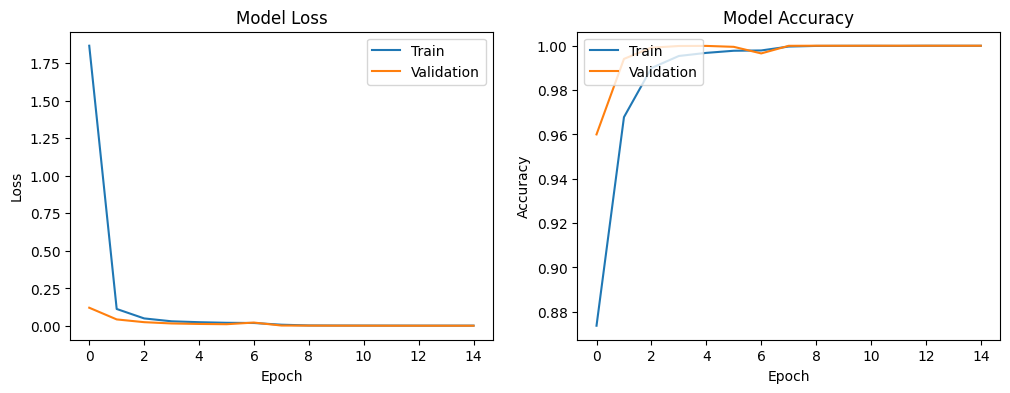

<Figure size 640x480 with 0 Axes>

In [46]:
model.save("/kaggle/working/final_model_BHSig.h5")

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(_.history['loss'], label='Train')
ax[0].plot(_.history['val_loss'], label='Validation')
ax[0].set_title('Model Loss')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper right')

ax[1].plot(_.history['accuracy'], label='Train')
ax[1].plot(_.history['val_accuracy'], label='Validation')
ax[1].set_title('Model Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper left')

plt.show()
plt.savefig('/kaggle/working/results.png')

# **Evaluation**

In [4]:
from tensorflow.keras.models import load_model
model=load_model("/kaggle/input/modelcnnbhsig/final_model_BHSig.h5")

In [26]:
# from tensorflow.keras.utils import plot_model

# plot_model(
#     model,
#     to_file='/kaggle/working/model_BHSig.png',
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=False,
#     dpi=1024,
#     layer_range=None,
#     show_layer_activations=True,
# )

In [15]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
import numpy as np 

# print(X1_val)

X1_pred = returnImageList(X1_val)
X2_pred = returnImageList(X2_val)
threshold = 0.80

Y_pred = (model.predict([X1_pred, X2_pred]) >= threshold).astype(int)

934/934 [==============================] - 866s 926ms/step


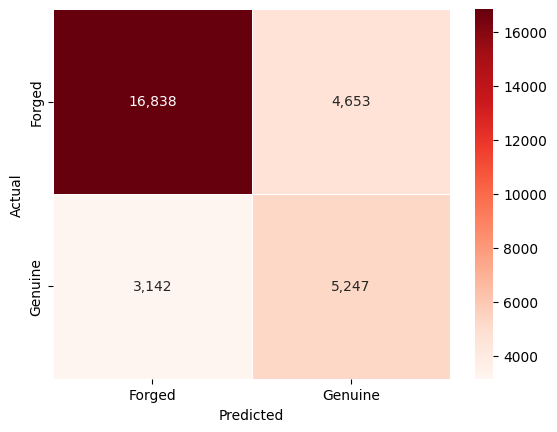

AttributeError: module 'matplotlib.pyplot' has no attribute 'save'

In [16]:
cm = confusion_matrix(Y_val,Y_pred)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm, annot=True, cmap='Reds', linewidth=.5, fmt=',.0f'
            , yticklabels=['Forged', 'Genuine'], xticklabels=['Forged', 'Genuine']
           )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
plt.save('/kaggle/working/cm.png')

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.84      0.78      0.81     21491
         1.0       0.53      0.63      0.57      8389

    accuracy                           0.74     29880
   macro avg       0.69      0.70      0.69     29880
weighted avg       0.75      0.74      0.75     29880

Accuracy Score:  0.7391231593038822
F1 Score:  0.7391231593038822
Precision Score:  0.6863713713713714
Recall Score:  0.70447633899359


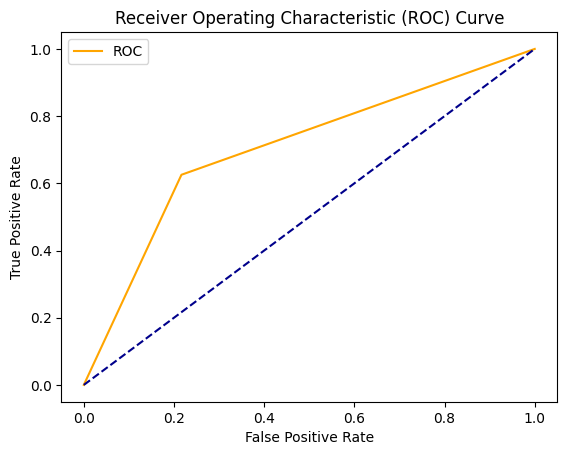

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, roc_curve
print('Classification Report: \n', classification_report(Y_val, Y_pred))
print('Accuracy Score: ',accuracy_score(Y_val, Y_pred, normalize=True))
print('F1 Score: ', f1_score(Y_val, Y_pred, average="micro"))
print('Precision Score: ',precision_score(Y_val, Y_pred, average="macro"))
print('Recall Score: ', recall_score(Y_val, Y_pred, average="macro"))

def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()
    
probs = Y_pred  
fper, tper, thresholds = roc_curve(Y_val, probs) 
plot_roc_cur(fper, tper)

In [18]:
fner = 1 - tper
eer_threshold = str(threshold)[np.nanargmin(np.absolute(fner - fper))]
EER = fper[np.nanargmin(np.absolute((fner - fper)))]
print(EER)

0.2165092364245498


In [36]:
print(accuracy_score(Y_val, Y_pred, normalize=True))

0.9999163354946664


In [37]:
print(f1_score(Y_val, Y_pred, average="micro"))

0.9999163354946664


In [38]:
print(precision_score(Y_val, Y_pred, average="macro"))

0.9999422799422799


In [39]:
print(recall_score(Y_val, Y_pred, average="macro"))

0.9998480704952901


### **On Training Set**
(Accuracy suggests that the model has avoided overfitting along with learning)

In [40]:
train_set_accuracy = model.evaluate(data_generator(batch_size,X1_train,X2_train,Y_train),batch_size=batch_size,steps=len(Y_val) // batch_size)

4781/4781 [==============================] - 1044s 218ms/step - loss: 0.0020 - accuracy: 1.0000


In [41]:
print("Training Set Accuracy is : ", train_set_accuracy[1]*100)

Training Set Accuracy is :  100.0


### **On Validation Set**
(Accuracy suggests how well the model has actually learnt)

In [42]:
validation_set_accuracy=model.evaluate(data_generator(batch_size,X1_val,X2_val,Y_val),batch_size=batch_size,steps=len(Y_val) // batch_size)

4781/4781 [==============================] - 1059s 222ms/step - loss: 0.0020 - accuracy: 1.0000


In [43]:
print("Validation Set Accuracy = ",validation_set_accuracy[1]*100)

Validation Set Accuracy =  100.0


### **On Dataset which is totally new for the model**
(Expected Accuracy is very low, just to get an idea on how well the model has learnt)

In [ ]:
test_preds = model.predict([returnImageList(set1_X1),returnImageList(set1_X2)])

In [ ]:
def calculateAccuracy(Y,predictions,threshold): # Calculates Accuracy on a given threshold value
    test_preds_final = []
    for i in predictions:
        if i[0]<0.35: test_preds_final.append(0)
        else: test_preds_final.append(1)

    counter=0
    for i in range(0,len(set1_Y)):
        if set1_Y[i] == test_preds_final[i]:
            counter+=1
    return counter*100/len(test_preds_final)

In [ ]:
mean = np.mean(test_preds)
print(mean)

In [ ]:
print("Accuracy gained by the totally new dataset is : ",calculateAccuracy(set1_Y,test_preds,np.mean(test_preds)))